## Information Theory
**FIZ371 - Scientific & Technical Computations | 27/04/2020**

**Information Theory**
* Introduction
* The Problem
* Reducing the error & Improving the reliability
* The probability of error
* Shannon - Weaver Communication Model
* Parity Concept
    * Application: Credit Card Number Validation (Luhn's Algorithm)
    * Application: IBAN Validation
    * Application TC ID # Validation
    * Hamming Code (7,4)
        * Examples
* Comparison of error-correction algorithms
* Shannon's Noisy-Channel Coding Theorem / Shannon's Limit (1948)
* References
  
Dr. Emre S. Tasci <emre.tasci@hacettepe.edu.tr>

# Introduction

Information theory is concerned with the delivery of a message from one point to the other. It has been established by Claude Shannon (1916-2001) in 1948, while working on telecommunication systems at the Bell Laboratories.

# The Problem
A digitized message (consisting of 1s and 0s, i.e. "bits") is transferred with a transfer ratio of 1 binary digit per second, and there is a probability of error that can "flip" the bit (i.e., transmitting a 1 as a 0 and vice-versa).

![IO.svg](images/IO.svg)

# Reducing the error & Improving the reliability

Send the source digit through the channel repeatedly.

**Ex: Repeating 3 times**
![IO_Repeated.png](images/IO_Repeated.png)

But it's still prone to errors. If, for the case of: 
* '0 $\rightarrow$ 000', more than one 0 are flipped $\rightarrow$ 1
* '1 $\rightarrow$ 111', more than one 1 are flipped $\rightarrow$ 0

# The probability of error
Given that the probability of a flip occuring for 1 digit being $\beta=\frac{1}{4}$, the probability that at least 2 of a sequence of 3 digits will be received incorrectly:

$\left( {n \choose k} = \frac{n!}{(n-k)!k!}\right)\,,\quad\quad {3 \choose 2}\left(\frac{1}{4}\right)^2\left(\frac{3}{4}\right)+{3 \choose 3}\left(\frac{1}{4}\right)^3=\frac{10}{64}=0.15625$

In [1]:
from scipy.special import comb
print(comb(3,2)*(1/4)**2*(3/4)+(comb(3,3)*(1/4)**3))

0.15625


General case for (2n+1) repetition and $\beta$ probability of error:

$$P\left(\begin{matrix}\text{n+1 or more}\\\text{digits in error}\\\text{ in a 2n+1 sequence}\end{matrix}\right)=\sum_{k=n+1}^{2n+1}{{2n+1}\choose k}\beta^k(1-\beta)^{2n+1-k}$$

2n+1  beta=0.1 beta=0.25
   1       0.1      0.25
   3     0.028   0.15625
   5   0.00856  0.103516
   7  0.002728  0.070557
   9  0.000891  0.048927
  11  0.000296  0.034328
  13  0.000099   0.02429
  15  0.000034    0.0173


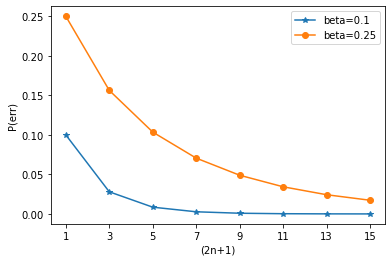

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

beta1 = 0.1
beta2 = 0.25
df = pd.DataFrame(columns=("2n+1","beta=0.1","beta=0.25"),index=np.arange(1,16,2))
for n in range(8):
    #print(2*n+1)
    p1 = 0
    p2 = 0
    for k in range(n+1,2*n+2):
        p1 += comb(2*n+1,k)*beta1**k*(1-beta1)**(2*n+1-k)
        p2 += comb(2*n+1,k)*beta2**k*(1-beta2)**(2*n+1-k)
    df.loc[2*n+1,"2n+1"] = 2*n+1
    df.loc[2*n+1,"beta=0.1"] = p1
    df.loc[2*n+1,"beta=0.25"] = p2
print(df.to_string(index=False))

plt.plot(df.loc[:,"2n+1"].values,df.iloc[:,1].values,"-*")
plt.plot(df.loc[:,"2n+1"].values,df.iloc[:,2].values,"-o")
plt.xlabel("(2n+1)")
plt.ylabel("P(err)")
plt.legend(["beta=0.1","beta=0.25"])
plt.xticks(range(1,16,2))
plt.show()

Effective transmission rate of the source is: 

$$\frac{1}{2n+1}$$ 

(actual intended message length / transmitted message length)

**Example:** A normal, noisy hard disk has an error probability of 0.1. In order to have a reliability in $10^{-15}$, what must the # of repetitions be?

In [3]:
import numpy as np
from scipy.special import comb

p_err = np.empty([0,2])
beta1 = 0.1

repetitions = np.array([1,2,3,4,5,6,7,10,20,50,59,61,62,63,64])
repetitions = (repetitions - 1)/2


def perr(n,beta):
    p1 = 0
    for k in np.arange(n+1,2*n+2):
        p1 += comb(2*n+1,k)*beta**k*(1-beta)**(2*n+1-k)
    return [2*n+1,p1]

print('{:>10} | {:<40}'.format("#","P(e)"))
for n in repetitions:
    p = perr(n,0.1)
    print('{:>10} | {:<40}'.format(p[0],p[1]))

         # | P(e)                                    
       1.0 | 0.1                                     
       2.0 | 0.050929581789406514                    
       3.0 | 0.028000000000000008                    
       4.0 | 0.015366182391318081                    
       5.0 | 0.008560000000000002                    
       6.0 | 0.004813890527660308                    
       7.0 | 0.002728000000000001                    
      10.0 | 0.000512414723086138                    
      20.0 | 2.304792882349986e-06                   
      50.0 | 3.335204046451669e-13                   
      59.0 | 3.1056495720556027e-15                  
      61.0 | 1.1003005338682953e-15                  
      62.0 | 6.550468634760461e-16                   
      63.0 | 3.9001884227808104e-16                  
      64.0 | 2.322466150634593e-16                   


62 hard disks!!! Way too many!

(We need to be smarter than this..)

# Shannon - Weaver Communication Model
![ShannonChannel.svg](images/ShannonChannel.svg)

This is the model Shannon (& Weaver) used to identify the essential stages for message relaying. Note how the noise is introduced only in the transfer channel.

# Parity Concept
Before we start on the Hamming Code, which improves the repeatition method, let's try to understand the parity concept: Parity checks are implemented when it is necessary to quickly validate long sequences where typing is highly prone to errors (e.g., credit card numbers, IBAN numbers, national ID numbers, etc.). One or more digits are also included in the resulting number that is dependent of the other digits, so that a quick validation reference is already available within the data to be validated.

## Application: Credit Card Number Validation ([Luhn's Algorithm](https://en.wikipedia.org/wiki/Luhn_algorithm))

0. Let the credit card number be: 4556 7375 8689 9855
1. Last digit is the check digit: 455673758689985<b><u>5</u></b>
2. Drop the last digit: 455673758689985
3. Reverse the numbers: 589986857376554
4. Multiply the digits in odd (1., 3., 5., ...) by 2: 10|8|18|9|16|6|16|5|14|3|14|6|10|5|8
5. Subtract 9 from any result higher that 9: 1 8 9 9 7 6 7 5 5 3 5 6 1 5 8
6. Add all the numbers together: 1+8+9+9+7+6+7+5+5+3+5+6+1+5+8 = 85
7. Multiply the sum by 9, take modulo 10 (divide by 10, get the remainder): 5 $\rightarrow$ this should be equal to the check digit

In [4]:
import numpy as np

num = "4556737586899855"

print("num (1):",num)
num_2 = list(num[:-1])
print("num (2):","".join(map(str,num_2)))
num_3 = num_2[::-1]
print("num (3): "+"".join(num_3))
num_4 = list(map(int,num_3))
for i in np.arange(0,len(num),2):
    num_4[i] = num_4[i] * 2
fmt = ('|'.join(['{:>2}']*len(num_4)))
print("num (4): "+fmt.format(*(list(map(str, num_4)))))
num_5 = np.array(num_4)
num_5[num_5>=10] -= 9
print("num (5): "+fmt.format(*num_5))
num_6 = np.sum(num_5)
print ("num (6): ",num_6)
print ("num (7): ",np.mod(num_6*9,10),"<-- Check digit")

num (1): 4556737586899855
num (2): 455673758689985
num (3): 589986857376554
num (4): 10| 8|18| 9|16| 6|16| 5|14| 3|14| 6|10| 5| 8
num (5):  1| 8| 9| 9| 7| 6| 7| 5| 5| 3| 5| 6| 1| 5| 8
num (6):  85
num (7):  5 <-- Check digit


**Proposition: Alternative to 7. step** 

At the 7. step, instead of taking the modulo 10 of sum multiplied by 9 and then comparing it to the check digit, just take the modulo 10 of the sum (without multiplying it by 9) and add it to the check digit -- the result must be either 0 or 10.

**_Homework: Why does this work? Prove that it does._**

## Application: IBAN Validation
0. Let the IBAN number be: TR40 0001 2345 6789 8765 4321 21
1. Move the four initial characters to the end: 0001234567898765432121TR40
2. Replace each letter in the string with two digits (A:10, B=11, ..., Z=35):  
0001234567898765432121292740
3. Divide this number by 97 $\rightarrow$ remainder must be: 1.

In [5]:
import numpy as np

IBAN = "TR400001234567898765432121"
print("IBAN (0): ",IBAN)

IBAN = IBAN[4:]+IBAN[0:4]
print("IBAN (1): ",IBAN)
s = len(IBAN)

IBAN_num = ""
for i in range(s):
    if(IBAN[i].isnumeric()):
        #print(IBAN[i],ord(IBAN[i])-48)
        IBAN_num += str(ord(IBAN[i])-48)
    else:
        #print("*",IBAN[i],ord(IBAN[i])-35)
        IBAN_num += str(ord(IBAN[i])-55)
print("IBAN (2): ",IBAN_num)
print("IBAN (3): ",np.mod(int(IBAN_num),97))

IBAN (0):  TR400001234567898765432121
IBAN (1):  0001234567898765432121TR40
IBAN (2):  0001234567898765432121292740
IBAN (3):  1


## Application TC ID # Validation

0. Let the TC ID# be: 12345678950
1. Add the digits in odd positions (1., 3.,...,9.) together, multiply by 7: 25*7=175
2. Add the digits in even positions (2., 4.,...,8.): 20
3. Subtract the sum in the 2nd step from the product in the 1st step: 175 - 20 = 155 
4. Take the modulo 10 -- this number must be equal to the 10th digit: $\rightarrow\, \mod_{10}(155)=5$ (1st check)
5. Add all the digits but the last one (1., 2.,...,10) -- modulo 10 of this sum must give you the 11th (last) digit: $50\rightarrow \mod_{10}(50)=0$ (2nd check)

In [6]:
import numpy as np

TCID = "12345678950"

print("TCID# (0): ",TCID)

TCID = np.array(list(map(int,TCID)))
#print(TCID)

s1 = np.sum(TCID[0:9:2])*7
print("TCID# (1): ",s1)

s2 = np.sum(TCID[1:8:2])
print("TCID# (2): ",s2)

s3 = s1 - s2
print("TCID# (3): ",s3)

print("TCID# (4): ",np.mod(s3,10)," == ",TCID[9])
print("TCID# (5): ",np.mod(np.sum(TCID[0:10]),10)," == ",TCID[10])

TCID# (0):  12345678950
TCID# (1):  175
TCID# (2):  20
TCID# (3):  155
TCID# (4):  5  ==  5
TCID# (5):  0  ==  0


Thus, TC ID # system uses a double check algorithm.

## Hamming Code (7,4)
* s: source message (length: 4)
* t: transmitted message (length: 7)

That means that we are using 7 bits to transmit 4 bits.

The extra 3 bits (located at the end) in the transmitted message contains the following parities (calculated as $\bmod_{2}{(sum)}$):

$$t_{1-4} = s_{1-4}\\
t_5 = (s_1,s_2,s_3)\\
t_6 = (s_2,s_3,s_4)\\
t_7 = (s_1,s_3,s_4)
$$

![HammingVenn.svg](images/HammingVenn.svg)

In [7]:
import numpy as np

sett = np.arange(2)

fmt = "{:^3} |{:^3} |{:^3} |{:^3} |{:^3} |{:^3} |{:^3}"

print(fmt.format("s1","s2","s3","s4","t5","t6","t7"))
print(fmt.format("---","---","---","---","---","---","---"))

for s1 in sett:
    for s2 in sett:
        for s3 in sett:
            for s4 in sett:
                t5 = np.mod(s1+s2+s3,2)
                t6 = np.mod(s2+s3+s4,2)
                t7 = np.mod(s1+s3+s4,2)
                print(fmt.format(s1,s2,s3,s4,t5,t6,t7))

s1  |s2  |s3  |s4  |t5  |t6  |t7 
--- |--- |--- |--- |--- |--- |---
 0  | 0  | 0  | 0  | 0  | 0  | 0 
 0  | 0  | 0  | 1  | 0  | 1  | 1 
 0  | 0  | 1  | 0  | 1  | 1  | 1 
 0  | 0  | 1  | 1  | 1  | 0  | 0 
 0  | 1  | 0  | 0  | 1  | 1  | 0 
 0  | 1  | 0  | 1  | 1  | 0  | 1 
 0  | 1  | 1  | 0  | 0  | 0  | 1 
 0  | 1  | 1  | 1  | 0  | 1  | 0 
 1  | 0  | 0  | 0  | 1  | 0  | 1 
 1  | 0  | 0  | 1  | 1  | 1  | 0 
 1  | 0  | 1  | 0  | 0  | 1  | 0 
 1  | 0  | 1  | 1  | 0  | 0  | 1 
 1  | 1  | 0  | 0  | 0  | 1  | 1 
 1  | 1  | 0  | 1  | 0  | 0  | 0 
 1  | 1  | 1  | 0  | 1  | 0  | 0 
 1  | 1  | 1  | 1  | 1  | 1  | 1 


s1  |s2  |s3  |s4  |t5  |t6  |t7 
--- |--- |--- |--- |--- |--- |---
 0  | 0  | 0  | 0  | 0  | 0  | 0 
 0  | 0  | 0  | 1  | 0  | 1  | 1 
 0  | 0  | 1  | 0  | 1  | 1  | 1 
 0  | 0  | 1  | 1  | 1  | 0  | 0 
 0  | 1  | 0  | 0  | 1  | 1  | 0 
 0  | 1  | 0  | 1  | 1  | 0  | 1 
 0  | 1  | 1  | 0  | 0  | 0  | 1 
 0  | 1  | 1  | 1  | 0  | 1  | 0 
 1  | 0  | 0  | 0  | 1  | 0  | 1 
 1  | 0  | 0  | 1  | 1  | 1  | 0 
 1  | 0  | 1  | 0  | 0  | 1  | 0 
 1  | 0  | 1  | 1  | 0  | 0  | 1 
 1  | 1  | 0  | 0  | 0  | 1  | 1 
 1  | 1  | 0  | 1  | 0  | 0  | 0 
 1  | 1  | 1  | 0  | 1  | 0  | 0 
 1  | 1  | 1  | 1  | 1  | 1  | 1
 
Note that any pair of codewords differ from each other in at least three bits!

**Syndromes (parities):**

$$z_1 = (t_5,s_1,s_2,s_3)\\
z_2 = (t_6,s_2,s_3,s_4)\\
z_3 = (t_7,s_1,s_3,s_4)$$

A syndrome $z=(z_1,z_2,z_3)$ is actually the combination of the parities of each circle's 4 components in the Venn diagram: We just add them up and then take 0 for even, 1 for odd (mod<sub>2</sub>).

Note that the parities are always 0 (even) for a healthy message (the syndrome is then: $z=(z_1,z_2,z_3) = (0,0,0)$:

In [8]:
import numpy as np

sett = np.arange(2)

fmt = "{:}-{:}-{:}-{:}|{:}-{:}-{:}|{:}-{:}-{:}"
print("{:^7}|{:^5}|{:^5}".format("s","t","z"))
print(fmt.format("1","2","3","4","5","6","7","1","2","3"))
print("-"*7+"|"+"-"*5+"|"+"-"*5)

for s1 in sett:
    for s2 in sett:
        for s3 in sett:
            for s4 in sett:
                t5 = np.mod(s1+s2+s3,2)
                t6 = np.mod(s2+s3+s4,2)
                t7 = np.mod(s1+s3+s4,2)
                z1 = np.mod(t5+s1+s2+s3,2)
                z2 = np.mod(t6+s2+s3+s4,2)
                z3 = np.mod(t7+s1+s3+s4,2)

                print(fmt.format(s1,s2,s3,s4,t5,t6,t7,z1,z2,z3))

   s   |  t  |  z  
1-2-3-4|5-6-7|1-2-3
-------|-----|-----
0-0-0-0|0-0-0|0-0-0
0-0-0-1|0-1-1|0-0-0
0-0-1-0|1-1-1|0-0-0
0-0-1-1|1-0-0|0-0-0
0-1-0-0|1-1-0|0-0-0
0-1-0-1|1-0-1|0-0-0
0-1-1-0|0-0-1|0-0-0
0-1-1-1|0-1-0|0-0-0
1-0-0-0|1-0-1|0-0-0
1-0-0-1|1-1-0|0-0-0
1-0-1-0|0-1-0|0-0-0
1-0-1-1|0-0-1|0-0-0
1-1-0-0|0-1-1|0-0-0
1-1-0-1|0-0-0|0-0-0
1-1-1-0|1-0-0|0-0-0
1-1-1-1|1-1-1|0-0-0


### Examples
1\. `t=1000|101  
s1 = 1, s2 = s3 = s4 = 0
t5 = s1+s2+s3 = 1+0+0 = 1
t6 = s2+s3+s4 = 0+0+0 = 0
t7 = s1+s3+s4 = 1+0+0 = 1`

![HammingVenn_E01.svg](images/HammingVenn_E01.svg)

Now, let's assume that, during transmission, noise flips the 2nd bit, thus the received signal becomes:

$$1000101 \rightarrow r = 1000101 + \overline{0100000} = 1\underline{1}00101$$

If we are to draw the diagram for the message we received, then it would be like this:

![HammingVenn_E01r.svg](images/HammingVenn_E01r.svg)

Syndrome: z = (1,1,0)

From this syndrome, we see that something is wrong, because there are 1s among the parities.

Find a bit that lies in all the odd parity circles and outside of all the  even parity circles --> from the intersection of the odd parity circles, we see that r<sub>2</sub> should be flipped!

2\. $t_5$ flipped $\rightarrow r=1000\underline{0}01$

![HammingVenn_E02r.png](images/HammingVenn_E02r.png)

$z(1,0,0)\rightarrow r_5$ should be flipped

3\. $s_3$ flipped $\rightarrow r=10\underline{1}0101$

![HammingVenn_E03r.svg](images/HammingVenn_E03r.svg)

$z(1,1,1)\rightarrow r_3$ should be flipped

**Syndromes and fixes chart**

Syndrome z|000|001|010|011|100|101|110|111
---|---|---|---|---|---|---|---|---
Unflip this bit|none|$r_7$|$r_6$|$r_4$|$r_5$|$r_1$|$r_2$|$r_3$

4\. $t_3\, \&\, t_7$ are flipped $\rightarrow r=10\underline{1}010\underline{0}$

![HammingVenn_E04r.svg](images/HammingVenn_E04r.svg)

$z(1,1,0)\rightarrow r_2$ should be flipped:

### Probability of Error
Let's calculate the probability that two or more bits will be flipped (hence, the received and corrected message will still be wrong) when $\beta$, the probability that the noise will flip a bit be: 
* $\beta=1/4$:

$$
\begin{align*}P(err) &= \underbrace{{7\choose 2}\left(\frac{1}{4}\right)^2\left(\frac{3}{4}\right)^5}_{2:0.31146240}
+\underbrace{{7\choose 3}\left(\frac{1}{4}\right)^3\left(\frac{3}{4}\right)^4}_{3:0.17303467}+\underbrace{\dots}_{\begin{matrix}4:\,0.05767822\\\,5:0.01153564\\6:\,0.00128174\end{matrix}}+\underbrace{{7\choose 7}\left(\frac{1}{4}\right)^7}_{7:\,0.00006104}\\
&=0.55505
\end{align*}
$$

In [9]:
import numpy as np
from scipy.special import comb

beta = 0.25
i_beta = 1 - beta

result = np.empty([6,2])
result[:,0] = range(2,8)
for k in range(2,8):
    result[k-2,1] = comb(7,k)*beta**k*i_beta**(7-k)
np.set_printoptions(precision=8,suppress=True)
print(result)
print("\nP(err): {:7.5f}".format(np.sum(result[:,1])))

[[2.         0.3114624 ]
 [3.         0.17303467]
 [4.         0.05767822]
 [5.         0.01153564]
 [6.         0.00128174]
 [7.         0.00006104]]

P(err): 0.55505


* $\beta=0.1$:  

$$
\begin{align*}P(err) &= \underbrace{{7\choose 2}\left(\frac{1}{10}\right)^2\left(\frac{9}{10}\right)^5}_{2:0.1240029}
+\underbrace{{7\choose 3}\left(\frac{1}{10}\right)^3\left(\frac{9}{10}\right)^4}_{3:0.0229635}+\underbrace{\dots}_{\begin{matrix}4:\,0.0025515\\\,5:0.0001701\\6:\,0.0000063\end{matrix}}+\underbrace{{7\choose 7}\left(\frac{1}{10}\right)^7}_{7:\,0.0000001}\\
&=0.14969
\end{align*}$$

In [10]:
import numpy as np
from scipy.special import comb

beta = 0.1
i_beta = 1-beta

result = np.empty([6,2])
result[:,0] = range(2,8)
for k in range(2,8):
    result[k-2,1] = comb(7,k)*beta**k*i_beta**(7-k)
np.set_printoptions(precision=8,suppress=True)
print(result)
print("\nP(err): {:7.5f}".format(np.sum(result[:,1])))

[[2.        0.1240029]
 [3.        0.0229635]
 [4.        0.0025515]
 [5.        0.0001701]
 [6.        0.0000063]
 [7.        0.0000001]]

P(err): 0.14969


# Comparison of error-correction algorithms
![MacKay_1_18.png](images/MacKay_1_18.png)
[David MacKay - Information Theory, Inference, and Learning Algorithms](https://www.inference.org.uk/mackay/itila/book.html)

In the graph above, repetition algorithms (_R#_) are compared against Hamming(7,4) code and more widely used BCH ([Bose–Chaudhuri–Hocquenghem](https://en.wikipedia.org/wiki/BCH_code)) codes.

# Shannon's Noisy-Channel Coding Theorem / Shannon's Limit (1948)

Shannon proposed an upper limit for which he defined as the channel capacity which can not be overcome by any algorithm (even in the ideal limit).

Channel capacity $C(\beta)$ is defined in terms of entropy $H_2$:

$$C(\beta) = 1 - H_2(\beta) = 1 -\left[\beta\log_2{\frac{1}{\beta}}+(1-\beta)\log_2{\frac{1}{1-\beta}}\right]$$

We can also use mutual information $I$ to calculate $C$:

$$C=\sup\limits_{P_R(x)} I(X;Y)$$

$$
\begin{align}
I(X;Y)&=H(X)-H(X|Y)\\
&=H(Y)-H(Y|X)\\
&=H(X)+H(Y)-H(X,Y)\\
&=H(X,Y)-H(X|Y)-H(Y|X)
\end{align}
$$

and taking $R(p_b)$ as the required repetition, for a given probability error, we have:

$$R(p_b) = \frac{C}{1-H_2(p_b)}$$

As an example, for $\beta=0.1$, $C\approx0.531$. 

$$C(\beta) = 1-H_2(\beta)=1-[0.1\,\log_2{\frac{1}{0.1}}+(1-0.1)\log_2{\frac{1}{1-0.1}}]=0.531$$

In [11]:
import numpy as np
beta = 0.1
C = 1-(beta*np.log2(1/beta)+(1-beta)*np.log2(1/(1-beta)))
print(C)

0.5310044064107187


Combining it with our previous faulty hard disk example for the desired $p(e)<10^{-15}$:  
Since $C=0.531$, $R=\frac{1}{2}=0.5\,(<0.531)$. Therefore, in theory, <u>two harddisks</u> are sufficient for arbitrarily small error probability ($\epsilon>0$).

![MacKay_1_19.png](images/MacKay_1_19.png)
[David MacKay - Information Theory, Inference, and Learning Algorithms](https://www.inference.org.uk/mackay/itila/book.html)

# References:
* The lecture textbook: David MacKay, "Information Theory, Inference, and Learning Algorithms" http://www.inference.org.uk/mackay/itprnn/book.html